# DECODE - Fit SMLM Data
The purpose of this notebook is to demonstrate the fitting procedure for a pretrained model.
Please be advised to have a read of the Introduction notebook first.

In [2]:
import sys

import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

print(f"DECODE version: {decode.utils.bookkeeping.decode_state()}")

DECODE version: vINVALID-recent-0.10.0


## Set parameters
Set device for inference (i.e. CUDA vs. CPU, for our setup inference on the CPU is about 10 times slower). If you fit on CPU though, you may want to change the number of threads if you have a big machine (see below).

In [3]:
device = 'cuda:0'  # or 'cpu', or you change cuda device index
threads = 4  #  number of threads, useful for CPU heavy computation. Change if you know what you are doing.
worker = 0  # number of workers for data loading. Used a default of 0 for safety. Multiprocessing on windows is sometimes not stable

torch.set_num_threads(threads)  # set num threads

if device != 'cpu':
    if not torch.cuda.is_available():
        raise ValueError("You have selected a non CPU device, but CUDA is not available."
                         "Refer to CPU version or check your installation.")

## Specify paths for the model, parameters and frames
If you trained you own model (using the Training notebook) you can specify it's path here.

**Important** If the camera parameters of the training differ from the data which should be fitted (e.g. different EM gain), you can try to use the model anyways, but you must specify them here since we convert to photon units before forwarding through the model.

In [4]:
# here you need to specify the parameters with suffix _run.yaml in your model's output folder (not param_run_in.yaml)
param_path = 'training/param_run.yaml'
model_path = 'training/model_0.pt'
frame_path = 'P1-Cy3b_001.tif'

# specify camera parameters of tiffs
meta = {
    'Camera': {
        'baseline': 500,
        'e_per_adu': 3.0,
        'em_gain': 20.0,
        'spur_noise': 0  # if you don't know, you can set this to 0.
    }
}

Alternatively if you just want to check out the fitting procedure we provide several example data for trying out DECODE. For this we load a gateway file which includes the links to the respective data.

In [26]:
gateway = decode.utils.example_helper.load_gateway()

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
package = gateway['examples']['experimental_data_workflow']

# get paths to files
zip_folder = decode.utils.example_helper.load_example_package(
    path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'])

frame_path = zip_folder / 'frames.tif'
meta_path = zip_folder / 'frames_meta.yaml'
model_path = zip_folder / 'model.pt'
param_path = zip_folder / 'param_run.yaml'

# load meta information (em gain of tif etc.)
with meta_path.open('r') as f:
    meta = yaml.safe_load(f)

Found file already in Cache.


## Load Parameters and Model
Specify Post-Processing as by the parameter file you trained the model with

In [5]:
param = decode.utils.param_io.load_params(param_path)
# param = decode.utils.param_io.load_params("param_friendly.yaml")
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                            input_file=model_path,
                                            output_file=None).load_init(device=device)

Model instantiated.
Model SHA-1 hash: ad1944afba98af66a685852ffe88e1f8874eecce
Loaded pretrained model: training\model_0.pt


In [6]:
# overwrite camera
param = decode.utils.param_io.autofill_dict(meta['Camera'], param.to_dict(), mode_missing='include')
param = decode.utils.param_io.RecursiveNamespace(**param)

## Load and Process Frames
Load TIFF file.
Change only needed if you load a custom tif file.
Note that the TIFF loader will auto-load and concatenate tiff files
that are consecutive and share
the same meta data. For example specifying `dummy.tif` will also load  `dummy_0.tif, dummy_1.tif` if present in the
same folder.
If you have single page tiff files, you can also specify a folder.

In [7]:
# depends on your input, e.g. load a tiff
frames = decode.utils.frames_io.load_tif(frame_path)

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.device = 'cpu'

## Set Up Pre- and Post-Processing
In the following we will set up the processing pipeline.

### Frame-Processing
**WARNING: Mirror2D** Depending on your specific camera setup you need to modify the following pipeline. In our case (using an EM-CCD camera) the beads are acquired without EM-Gain, while the experimental frames were acquired with EM-Gain. For our camera, due to some hardware specifics, EM-Gain enabled will lead the frames to be mirrored in the last dimension. Since the trained model and the experimental frames need to be consistent with respect to the PSF, we account for this mirroring by `Mirror2D(dims=-1)`.

Depending on your individual camera you might be able to omit this. Particularly if you are using a sCMOS camera.

**AutoCenterCrop** Due to peculiarities of training a Deep Learning model, the size of the input frame is slightly restricted. In our case the input frame size must be in multitudes of 8 per edge. For this reason we ***center crop*** the frame to a size that satisfies this requirement. That means an input frame of size 34 x 41 would be cropped to 32 x 40 and only fitted in this region. If you want to use a non-destructive method you could replace `AutoCenterCrop` by `AutoPad`, however this could lead to a distortion at the frame border which is why we recommend `AutoCenterCrop`.

In [8]:
# setup frame processing as by the parameter with which the model was trained
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.frame_processing.Mirror2D(dims=-1),  # WARNING: You might need to comment this line out. see above
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

# determine extent of frame and its dimension after frame_processing
size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.unsqueeze(1).size(), frame_proc.forward)  # frame size after processing
frame_extent = ((-0.5, size_procced[-2] - 0.5), (-0.5, size_procced[-1] - 0.5))


# Setup post-processing
# It's a sequence of backscaling, relative to abs. coord conversion and frame2emitter conversion
post_proc = decode.neuralfitter.utils.processing.TransformSequence([

    decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),

    decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                          yextent=frame_extent[1],
                                                          img_shape=size_procced[-2:]),

    decode.neuralfitter.post_processing.SpatialIntegration(raw_th=0.1,
                                                          xy_unit='px',
                                                          px_size=param.Camera.px_size)


])

## Fit the Data

In [9]:
infer = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
                                  frame_proc=frame_proc, post_proc=post_proc,
                                  device=device, num_workers=worker)

emitter = infer.forward(frames[:])

100%|████████████████████████████████████████████████████████████████████████████████| 455/455 [29:30<00:00,  3.89s/it]


In [11]:
# check on the output
print(emitter)

EmitterSet
::num emitters: 2408295
::xy unit: px
::px size: tensor([160., 160.])
::frame range: 0 - 4999
::spanned volume: [  -0.42947832   -0.46154046 -408.4985    ] - [295.5921  295.61218 409.1642 ]


You can check if the predictions look reasonable on a random frame

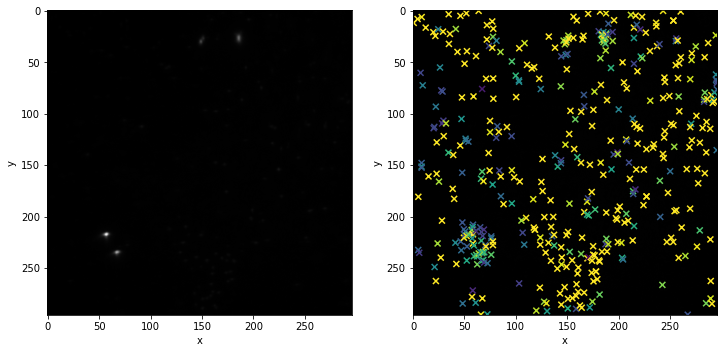

In [25]:
random_ix = torch.randint(frames.size(0), size=(1, )).item()

em_subset = emitter.get_subset_frame(random_ix, random_ix)

plt.figure(figsize=(12, 6))
plt.subplot(121)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]])).plot()

plt.subplot(122)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]]),
                           pos_out=em_subset.xyz_px, phot_out=em_subset.prob).plot()

plt.show()

Here we compare the inferred distribution of the photon numbers and background values with the ranges used during training.
If the inferred values fall outside of the green regions, or are concentrated in a small subspace of it, it might make sense to adjust the simulation parameters and retrain the the network.

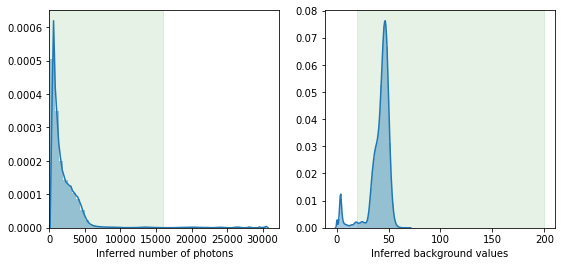

In [13]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
mu, sig = param.Simulation.intensity_mu_sig
plt.axvspan(0, mu + sig * 3, color='green', alpha=0.1)
sns.distplot(emitter.phot.numpy())
plt.xlabel('Inferred number of photons')
plt.xlim(0)

plt.subplot(132)
plt.axvspan(*param.Simulation.bg_uniform, color='green', alpha=0.1)
sns.distplot(emitter.bg.numpy())
plt.xlabel('Inferred background values')

plt.show()

## Postprocessing

DECODE will in general detect very high numbers of emitters, including those with high uncertainties.
Fortunately every DECODE prediction includes uncertainty estimates in x,y and z which we plot here.

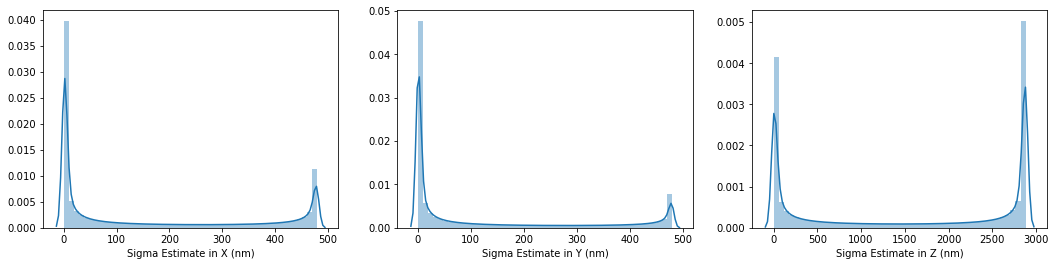

In [24]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(emitter.xyz_sig_nm[:, 0].numpy())
plt.xlabel('Sigma Estimate in X (nm)')

plt.subplot(132)
sns.distplot(emitter.xyz_sig_nm[:, 1].numpy())
plt.xlabel('Sigma Estimate in Y (nm)')

plt.subplot(133)
sns.distplot(emitter.xyz_sig_nm[:, 2].numpy())
plt.xlabel('Sigma Estimate in Z (nm)')


plt.show()

We provide a simple histogram rendering procedure for initial evaluation. You can specify the pixel size in nm, the sigma value for a Gaussian blur, and a clipping value and contrast to control the brightness.
The histogram takes an Emitterset as input, and optionally also a vector of the same length which adds a color dimension.
Below we plot the x-y view with z as colordimension as well as the x-z view.
On the right side we instead color by the combined inferred uncertainty. This highlights some artifacts (red spots) and how the uncertainty is driven by the z location and the density.

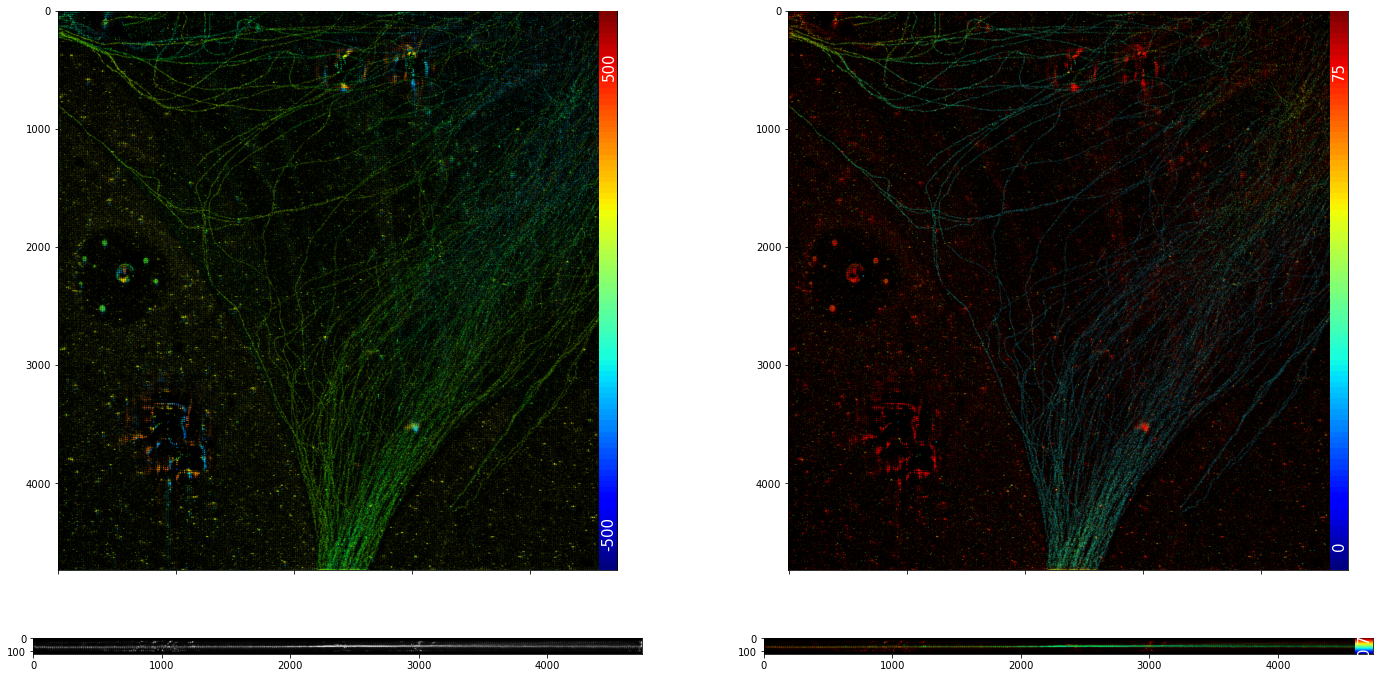

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(24, 12), sharex='col',
                        gridspec_kw={'height_ratios': [1, 1200 / 20000]})

decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=1,
                           zextent=[-600, 600], colextent=[-500, 500], plot_axis=(0, 1),
                           contrast=1.25).render(emitter, emitter.xyz_nm[:, 2], ax=axs[0, 0])
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=50,
                           zextent=[-600, 600], plot_axis=(0, 2)).render(emitter, ax=axs[1, 0])

decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=1,
                           zextent=[-600, 600], colextent=[0, 75], plot_axis=(0, 1),
                           contrast=1.25).render(emitter, emitter.xyz_sig_weighted_tot_nm, ax=axs[0, 1])

decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=50,
                           zextent=[-600, 600], colextent=[0, 75], plot_axis=(0, 2)).\
    render(emitter, emitter.xyz_sig_weighted_tot_nm, ax=axs[1, 1])

plt.show()

It is almost always beneficial for the image quality to remove the worst localizations.
Below we remove all localizations with uncertainties that exceed 40 nm in x,y or 80 nm in z.
This leaves us with 74% of the detections. Alternatively you can specify the remaining percentage directly with the `emitter.filter_by_sigma(fraction)` method which will remove the emitters with the lowest combined uncertainty.
If you compare the rendering to the previous (unfiltered) one, you can see that this procedure eliminated all visible artefacts. However it also removed out of focus tubules in the top right corner that where previously visible.

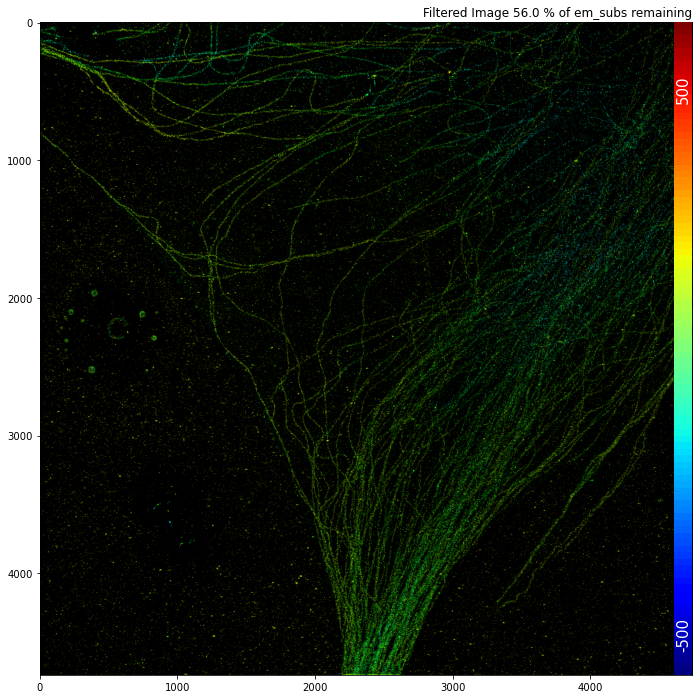

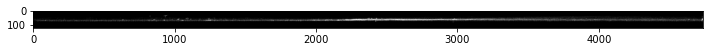

In [21]:
sigma_x_high_threshold = 40
sigma_y_high_threshold = 40
sigma_z_high_threshold = 80

em_sub = emitter[
    (emitter.xyz_sig_nm[:, 0] <= sigma_x_high_threshold)
    * (emitter.xyz_sig_nm[:, 1] <= sigma_x_high_threshold)
    * (emitter.xyz_sig_nm[:, 2] <= sigma_z_high_threshold)
    ]
# em_sub = emitter.filter_by_sigma(0.67)  # alternatively

plt.figure(figsize=(12, 12))
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=1,
                           zextent=[-600, 600], colextent=[-500, 500], plot_axis=(0, 1),
                           contrast=1.5).render(em_sub, em_sub.xyz_nm[:, 2])
plt.title(
    f'Filtered Image {np.round(100 * len(em_sub) / len(emitter))} % of em_subs remaining', loc='right')
plt.show()
plt.figure(figsize=(12, 3))
decode.renderer.Renderer2D(px_size=10., sigma_blur=5., rel_clip=None, abs_clip=50,
                           zextent=[-600, 600], plot_axis=(0, 2)).render(em_sub)

plt.show()

Instead of removing localizations you can also plot all of them and account for their uncertainty by rendering every localization as a Gaussian with a two dimensional standard deviation equal to the predicted uncertainty.
Below we compare plotting with a constant sigma blur, and with individually rendered Gaussians. The second option removes artifacts and correctly blurs out of focus structures.

More advanced plotting routines are for example available in the SMAP package (https://github.com/jries/SMAP)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00, 10.39it/s]


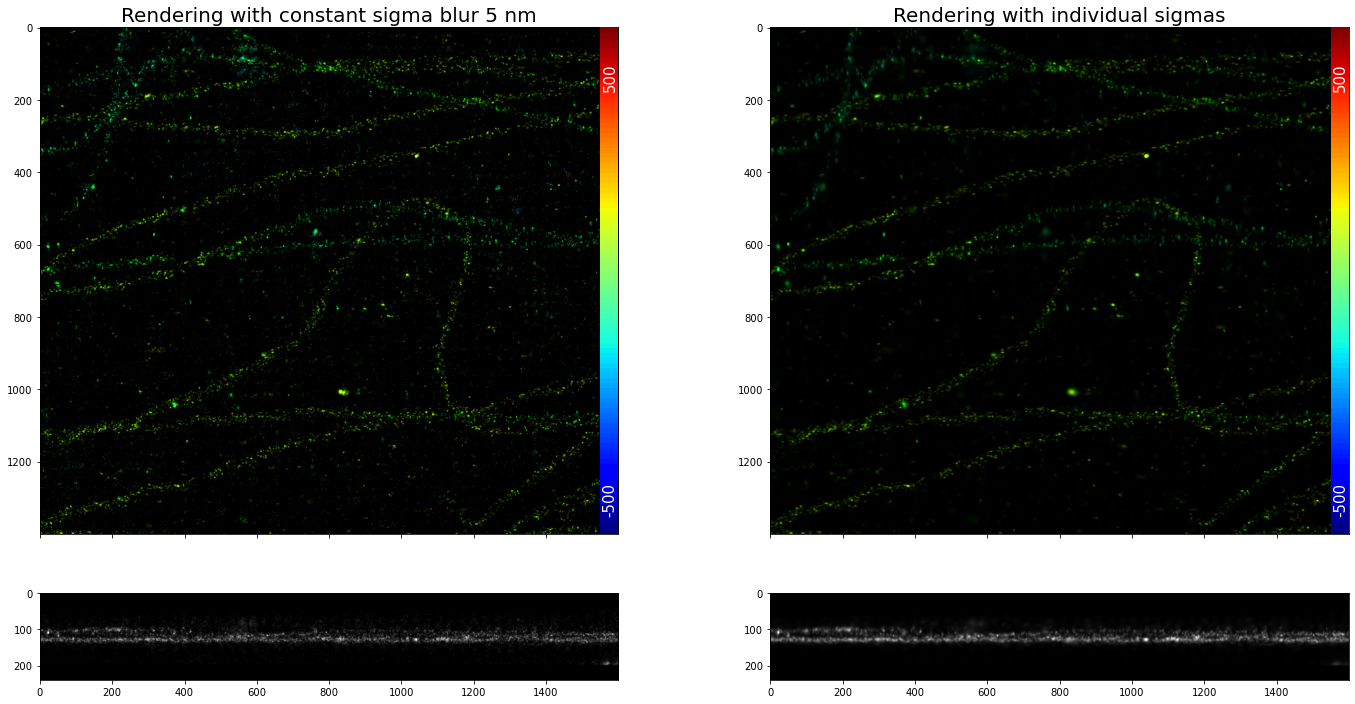

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(24, 12), sharex='col',
                        gridspec_kw={'height_ratios': [1, 1200 / 7000]})
extents = {
    'xextent': [14000, 22000],
    'yextent': [1000, 8000],
    'zextent': [-600, 600],
    'colextent': [-500, 500]
}

decode.renderer.Renderer2D(
    px_size=5., sigma_blur=5., rel_clip=None, abs_clip=3, **extents,
    plot_axis=(0, 1), contrast=3).render(emitter, emitter.xyz_nm[:, 2], ax=axs[0, 0])

decode.renderer.Renderer2D(
    px_size=5., sigma_blur=5., rel_clip=None, abs_clip=15, **extents,
    plot_axis=(0, 2), contrast=2).render(emitter, ax=axs[1, 0])

decode.renderer.RendererIndividual2D(
    px_size=5., filt_size=20, rel_clip=None, abs_clip=3, **extents,
    plot_axis=(0, 1), contrast=3).render(emitter, emitter.xyz_nm[:, 2], ax=axs[0, 1])

decode.renderer.RendererIndividual2D(
    px_size=5., filt_size=20, rel_clip=None, abs_clip=3, **extents,
    plot_axis=(0, 2)).render(emitter, ax=axs[1, 1])

axs[0, 0].set_title('Rendering with constant sigma blur 5 nm', fontsize=20)
axs[0, 1].set_title('Rendering with individual sigmas', fontsize=20)


plt.show()

## Save EmitterSet
We support `.h5 .csv and .pt` to save an EmitterSet to file. Please consult the Introduction notebook for more
information.

In [23]:
emitter.save('emitter.h5')  # or '.csv' or '.pt'